**Name: Javad Hezareh**
<br>
**Std-ID: 98101074**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 1024

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 105494640.77it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.feature_extractor = nn.Sequential(
            *list(resnet18(pretrained=True).children())[:-2])
        self.fc = nn.Linear(512, 10)

    def get_features(self, x):
      return self.feature_extractor(x)

    def forward(self, x):
        feature = self.get_features(x)
        return F.softmax(self.fc(torch.flatten(feature, start_dim=1)), dim=1)

In [92]:
model = Net().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [93]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 10

In [94]:
model.train()
losses = []
accs = []

for epoch in range(num_epochs):
    #### To Do (4 pts) #####
    # Fine-tune model on CIFAR-10 dataset
    total_loss = 0
    N = 0
    acc = 0
    with tqdm(enumerate(trainloader), total=len(trainloader)) as pbar:
        for i, (imgs, labels) in pbar:
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            probs = model(imgs)
            loss = criterion(probs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(labels)
            N += len(labels)
            acc += (torch.argmax(probs, dim=1) == labels).sum()
    print(f'\nEpoch: {epoch}\ttotal_loss: {total_loss/N:.3e}\taccuracy: {acc/N:.2f}\n')
    losses.append(total_loss / N)
    accs.append(acc / N)
    ################

100%|██████████| 49/49 [00:15<00:00,  3.20it/s]


Epoch: 0	total_loss: 1.825e+00	accuracy: 0.64




100%|██████████| 49/49 [00:14<00:00,  3.29it/s]


Epoch: 1	total_loss: 1.728e+00	accuracy: 0.73




100%|██████████| 49/49 [00:16<00:00,  3.02it/s]


Epoch: 2	total_loss: 1.710e+00	accuracy: 0.75




100%|██████████| 49/49 [00:15<00:00,  3.13it/s]


Epoch: 3	total_loss: 1.701e+00	accuracy: 0.76




100%|██████████| 49/49 [00:15<00:00,  3.17it/s]


Epoch: 4	total_loss: 1.676e+00	accuracy: 0.78




100%|██████████| 49/49 [00:14<00:00,  3.29it/s]


Epoch: 5	total_loss: 1.670e+00	accuracy: 0.79




100%|██████████| 49/49 [00:14<00:00,  3.28it/s]


Epoch: 6	total_loss: 1.665e+00	accuracy: 0.80




100%|██████████| 49/49 [00:14<00:00,  3.27it/s]


Epoch: 7	total_loss: 1.656e+00	accuracy: 0.80




100%|██████████| 49/49 [00:15<00:00,  3.17it/s]


Epoch: 8	total_loss: 1.654e+00	accuracy: 0.81




100%|██████████| 49/49 [00:15<00:00,  3.15it/s]


Epoch: 9	total_loss: 1.642e+00	accuracy: 0.82



In [95]:
def poisoning_example_generation(t, b, f, lmda=0.1, max_iters=10, beta=1):
    """
    t: target instance
    b: base instance
    f: feature extractor
    lambda: learning rate
    """
    #### To Do (9 pts) #####
    # Create poisoned sample by following the algorithm you've learned in the class
    x = torch.clone(b)

    loss_fn = lambda y: torch.linalg.norm(f(y)-f(t))**2
    for i in range(max_iters):
        x = x.detach()
        x.requires_grad = True
        loss = loss_fn(x)
        loss.backward()

        x_hat = x - lmda * x.grad
        x = (x_hat + lmda*beta*b)/(1 + beta*lmda)
        x = torch.clamp(x, 0, 1)

    sample = x.detach()
    ################
    return sample

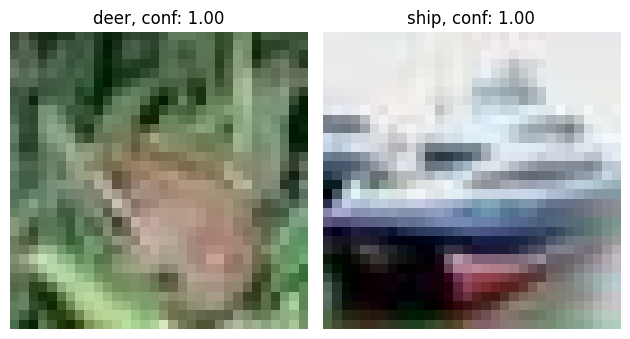

In [96]:
#### To Do (2 pts) #####
# Show the frog and ship images
# Evaluate model on them (compute predicted label)
from torchvision.io import read_image

frog = (read_image('frog.jpeg').unsqueeze(0) / 255).to(device)
ship = (read_image('ship.jpeg').unsqueeze(0) / 255).to(device)

model.eval()
imgs = torch.cat([frog, ship], dim=0).to(device)
probs = model(imgs)
conff, preds = torch.max(probs, dim=1)

fig, axis = plt.subplots(1, 2)
for i in range(2):
    axis[i].imshow(imgs[i].permute([1, 2, 0]).cpu().numpy())
    axis[i].set_title(f'{classes[preds[i]]}, conf: {conff[i]:.2f}')
    axis[i].axis('off')
fig.tight_layout();
################

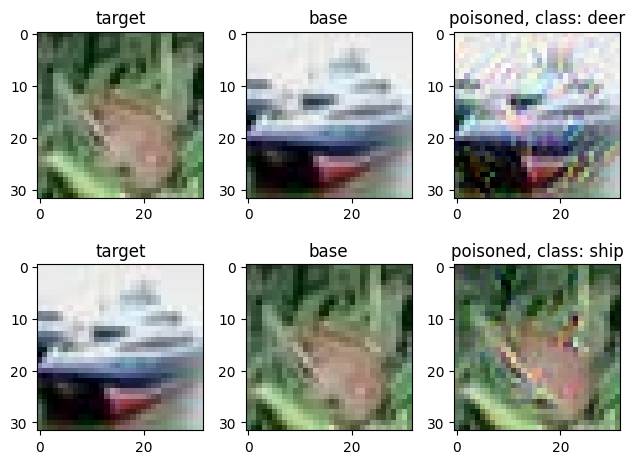

In [103]:
#### To Do (2 pts) #####
# Create poisoned samples
# Evaluate model on them (compute predicted label)
model.eval()
f = lambda y: model.get_features(y)

frog_ship = poisoning_example_generation(frog, ship, f, lmda=0.001, max_iters=500)
ship_frog = poisoning_example_generation(ship, frog, f, lmda=0.001, max_iters=500)
poisoned_samples = torch.cat([frog_ship, ship_frog], dim=0)

probs = model(poisoned_samples)
conff, preds = torch.max(probs, dim=1)

fig, axis = plt.subplots(2, 3)

for i in range(2):
    axis[i, 0].imshow(imgs[i].permute([1, 2, 0]).cpu().numpy())
    axis[i, 1].imshow(imgs[1-i].permute([1, 2, 0]).cpu().numpy())
    axis[i, 2].imshow(poisoned_samples[i].permute([1, 2, 0]).cpu().numpy())

    axis[i, 0].set_title('target')
    axis[i, 1].set_title('base')
    axis[i, 2].set_title(f'poisoned, class: {classes[preds[i]]}')
fig.tight_layout()
################